# Floor Plan Generator Model Implementation

**Date:** 2025-03-24
**User:** MazharRehan

This notebook implements a Conditional GAN model to generate floor plans based on the dataset of 5, 10, and 20 Marla plot designs.

## 1. Setup and Installation

First, let's set up our environment and import the necessary libraries.

In [6]:
!python --version
!pip install tensorflow

Python 3.11.11


In [7]:
!pip install --upgrade pip setuptools wheel

In [11]:
# Install any additional packages if needed
# !pip install -q matplotlib==3.5.1 tensorflow==2.8.0 scikit-learn==1.0.2 seaborn==0.11.2 tqdm
!pip install -q matplotlib tensorflow scikit-learn seaborn tqdm

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import json
from datetime import datetime
from google.colab import drive
from tqdm import tqdm

In [13]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Mount Google Drive to access your data
drive.mount('/content/drive')

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preparation

### 2.1 Define Parameters and Constants

In [14]:
# Define parameters
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_HEIGHT = 256  # Resized height
IMG_WIDTH = 256   # Resized width
NUM_CHANNELS = 3  # RGB
EPOCHS = 200
PLOT_TYPES = ['5_marla', '10_marla', '20_marla']
# Number of output channels = number of room types + walls
NUM_OUTPUT_CHANNELS = 24  # Based on your color coding scheme

# Define dataset path (on Google Drive)
DATASET_PATH = "/content/drive/MyDrive/Github/Model_1.0/dataset"  # Adjust this path to match your Drive structure

# Create output directories
OUTPUT_DIR = '/content/output'
CHECKPOINT_DIR = '/content/checkpoints'
LOG_DIR = '/content/logs'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Define the color mapping for visualization
COLOR_MAP = {
    'Bedroom': [255, 0, 0],          # Red
    'Bathroom': [0, 0, 255],         # Blue
    'Kitchen': [255, 165, 0],        # Orange
    'Drawing Room': [0, 128, 0],     # Green
    'Garage': [165, 42, 42],         # Brown
    'Lounge': [255, 255, 0],         # Yellow
    'Backyard': [50, 205, 50],       # Lime Green
    'Stairs': [0, 128, 128],         # Teal
    'Storage': [128, 0, 128],        # Purple
    'Open Space': [0, 255, 255],     # Cyan
    'Prayer Room': [127, 127, 127],  # Crimson
    'Staircase': [153, 51, 255],     # Violet
    'Lobby': [255, 0, 255],          # Magenta
    'Lawn': [64, 224, 208],          # Turquoise
    'Dining': [225, 192, 203],       # Pink
    'Servant': [75, 0, 130],         # Indigo
    'Passage': [128, 128, 0],        # Olive Green
    'Laundry': [230, 230, 250],      # Lavender
    'Dressing': [255, 127, 80],      # Coral
    'Side Garden': [255, 215, 0],    # Gold
    'Library': [255, 191, 0],        # Amber
    'Walls': [0, 0, 0],              # Black
    'Door': [128, 0, 0],             # Mahogany
    'Background': [255, 255, 255]    # White
}

# Create reverse mapping from RGB to room type index
RGB_TO_INDEX = {}
INDEX_TO_COLOR = []
for i, (room_type, color) in enumerate(COLOR_MAP.items()):
    RGB_TO_INDEX[tuple(color)] = i
    INDEX_TO_COLOR.append(color)

INDEX_TO_COLOR = np.array(INDEX_TO_COLOR)

### 2.2 Data Loading and Preprocessing Functions

In [15]:
def load_dataset(dataset_path, plot_types=None):
    """
    Load dataset from the given path for specified plot types.

    Args:
        dataset_path: Path to the dataset directory
        plot_types: List of plot types to include (e.g., ['5_marla', '10_marla'])

    Returns:
        images: List of floor plan images
        conditions: List of condition vectors (plot type one-hot encoded)
    """
    if plot_types is None:
        plot_types = PLOT_TYPES

    images = []
    conditions = []
    file_paths = []  # Store file paths for debugging

    for i, plot_type in enumerate(plot_types):
        plot_dir = os.path.join(dataset_path, plot_type)

        # Skip if directory doesn't exist
        if not os.path.exists(plot_dir):
            print(f"Warning: Directory {plot_dir} not found. Skipping.")
            continue

        files = [f for f in os.listdir(plot_dir) if f.endswith('.png')]

        print(f"Found {len(files)} images in {plot_type} directory")

        for file in tqdm(files):
            file_path = os.path.join(plot_dir, file)
            file_paths.append(file_path)

            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            # Normalize to [-1, 1]
            img_array = (img_array / 127.5) - 1

            # Create one-hot encoding for plot type condition
            condition = np.zeros(len(PLOT_TYPES))
            condition[i] = 1

            images.append(img_array)
            conditions.append(condition)

    if len(images) == 0:
        raise ValueError(f"No images found in the dataset at {dataset_path}")

    # Display a sample image
    plt.figure(figsize=(8, 8))
    plt.imshow((images[0] + 1) / 2)  # Convert from [-1, 1] to [0, 1] for display
    plt.title(f"Sample Image: {file_paths[0]}")
    plt.axis('off')
    plt.show()

    return np.array(images), np.array(conditions)

def preprocess_image_to_segmentation_map(image):
    """
    Convert an RGB image to a segmentation map based on color mapping.
    Each pixel will be assigned a class index based on its RGB value.

    Args:
        image: RGB image array with values in range [-1, 1]

    Returns:
        segmentation_map: Array of class indices
    """
    # Convert from [-1, 1] to [0, 255]
    img = ((image + 1) * 127.5).astype(np.uint8)

    # Initialize segmentation map with background class
    segmentation_map = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Assign class indices based on RGB values
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            rgb = tuple(img[y, x])
            # Find closest color in the color map
            closest_color = min(RGB_TO_INDEX.keys(),
                              key=lambda c: sum((c[i] - rgb[i])**2 for i in range(3)))
            segmentation_map[y, x] = RGB_TO_INDEX[closest_color]

    return segmentation_map

def preprocess_dataset(images, conditions):
    """
    Preprocess the dataset for training.

    Args:
        images: Array of floor plan images
        conditions: Array of condition vectors

    Returns:
        segmentation_maps: Array of segmentation maps
        conditions: Array of condition vectors
    """
    segmentation_maps = []

    for img in tqdm(images, desc="Creating segmentation maps"):
        segmentation_map = preprocess_image_to_segmentation_map(img)
        segmentation_maps.append(segmentation_map)

    # Display a sample segmentation map
    plt.figure(figsize=(8, 8))
    plt.imshow(segmentation_maps[0], cmap='tab20')
    plt.title("Sample Segmentation Map")
    plt.axis('off')
    plt.show()

    return np.array(segmentation_maps), conditions

## 3. Model Architecture

### 3.1 Loss Functions and Network Building Blocks

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    """
    Loss function for the generator.

    Args:
        disc_generated_output: Discriminator output on generated images
        gen_output: Generator output
        target: Ground truth segmentation maps

    Returns:
        total_loss: Combined adversarial and pixel-wise loss
    """
    # Binary cross entropy loss for the GAN
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(disc_generated_output), disc_generated_output)

    # Pixel-wise loss (sparse categorical crossentropy for segmentation)
    pixel_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(
        target, gen_output)

    # Total loss
    total_loss = gan_loss + 100 * pixel_loss  # Higher weight on pixel loss

    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Loss function for the discriminator.

    Args:
        disc_real_output: Discriminator output on real images
        disc_generated_output: Discriminator output on generated images

    Returns:
        total_loss: Discriminator loss
    """
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.zeros_like(disc_generated_output), disc_generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

def upsample_block(x, filters, kernel_size=4, strides=2, apply_dropout=False):
    """
    Upsampling block for the generator.

    Args:
        x: Input tensor
        filters: Number of filters
        kernel_size: Size of the kernel
        strides: Stride length
        apply_dropout: Whether to apply dropout

    Returns:
        x: Output tensor
    """
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides,
                              padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if apply_dropout:
        x = layers.Dropout(0.5)(x)

    x = layers.LeakyReLU(0.2)(x)

    return x

def downsample_block(x, filters, kernel_size=4, strides=2, apply_batchnorm=True):
    """
    Downsampling block for the generator and discriminator.

    Args:
        x: Input tensor
        filters: Number of filters
        kernel_size: Size of the kernel
        strides: Stride length
        apply_batchnorm: Whether to apply batch normalization

    Returns:
        x: Output tensor
    """
    x = layers.Conv2D(filters, kernel_size, strides=strides,
                     padding='same', use_bias=False)(x)

    if apply_batchnorm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(0.2)(x)

    return x

### 3.2 Generator and Discriminator Models

In [17]:
def build_generator():
    """
    Build the generator model (U-Net architecture).

    Returns:
        model: Generator model
    """
    # Input: Random noise + condition vector
    noise_input = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    condition_input = layers.Input(shape=[len(PLOT_TYPES)])

    # Expand condition to match spatial dimensions
    condition_expanded = layers.Dense(IMG_HEIGHT * IMG_WIDTH)(condition_input)
    condition_expanded = layers.Reshape((IMG_HEIGHT, IMG_WIDTH, 1))(condition_expanded)

    # Concatenate noise and condition
    x = layers.Concatenate()([noise_input, condition_expanded])

    # Encoder
    # For simplicity, we apply an initial convolution to combine the inputs
    x = layers.Conv2D(64, 4, strides=1, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    # Downsampling blocks
    encoder_outputs = []
    down_filters = [64, 128, 256, 512, 512, 512]

    for filters in down_filters:
        x = downsample_block(x, filters)
        encoder_outputs.append(x)

    # Bottleneck
    bottleneck = downsample_block(encoder_outputs[-1], 512)

    # Decoder with skip connections
    up_filters = [512, 512, 512, 256, 128, 64]
    apply_dropout = [True, True, True, False, False, False]

    x = bottleneck

    for i, (filters, dropout) in enumerate(zip(up_filters, apply_dropout)):
        x = upsample_block(x, filters, apply_dropout=dropout)
        # Skip connection (except for the last layer)
        if i < len(encoder_outputs):
            x = layers.Concatenate()([x, encoder_outputs[-(i+1)]])

    # Output layer (num channels = number of room types)
    output = layers.Conv2DTranspose(NUM_OUTPUT_CHANNELS, 4, strides=1,
                                   padding='same', activation=None)(x)

    return models.Model([noise_input, condition_input], output, name='generator')

def build_discriminator():
    """
    Build the discriminator model (PatchGAN).

    Returns:
        model: Discriminator model
    """
    # Input: Generated or real image + condition vector
    image_input = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    condition_input = layers.Input(shape=[len(PLOT_TYPES)])

    # Expand condition to match spatial dimensions
    condition_expanded = layers.Dense(IMG_HEIGHT * IMG_WIDTH)(condition_input)
    condition_expanded = layers.Reshape((IMG_HEIGHT, IMG_WIDTH, 1))(condition_expanded)

    # Concatenate image and condition
    x = layers.Concatenate()([image_input, condition_expanded])

    # Downsampling blocks
    filters = [64, 128, 256, 512]

    for i, f in enumerate(filters):
        # For the first layer, don't apply batch normalization
        x = downsample_block(x, f, apply_batchnorm=(i != 0))

    # Output layer (PatchGAN)
    output = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return models.Model([image_input, condition_input], output, name='discriminator')

## 4. FloorPlanGenerator Class

In [18]:
class FloorPlanGenerator:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.generator = build_generator()
        self.discriminator = build_discriminator()

        # Initialize optimizers
        self.generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

        # Setup checkpoint
        self.checkpoint_dir = CHECKPOINT_DIR
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )

        # Initialize logs
        self.log_dir = LOG_DIR
        self.summary_writer = tf.summary.create_file_writer(
            self.log_dir + "/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        )

    def load_and_preprocess_data(self):
        """
        Load and preprocess the dataset.

        Returns:
            train_dataset: TensorFlow dataset for training
            test_dataset: TensorFlow dataset for testing
        """
        print("Loading dataset...")
        images, conditions = load_dataset(self.dataset_path)

        print(f"Found {len(images)} images.")
        if len(images) == 0:
            raise ValueError("No images found in the dataset.")

        print("Preprocessing dataset...")
        segmentation_maps, conditions = preprocess_dataset(images, conditions)

        # Split into training and testing sets
        X_train, X_test, y_train, y_test, cond_train, cond_test = train_test_split(
            images, segmentation_maps, conditions, test_size=0.2, random_state=42
        )

        print(f"Training set: {len(X_train)} images, Test set: {len(X_test)} images")

        # Create TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((
            {'image': X_train, 'condition': cond_train}, y_train
        )).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

        test_dataset = tf.data.Dataset.from_tensor_slices((
            {'image': X_test, 'condition': cond_test}, y_test
        )).batch(BATCH_SIZE)

        return train_dataset, test_dataset

    @tf.function
    def train_step(self, input_image, target, condition):
        """
        Training step for the GAN.

        Args:
            input_image: Input image
            target: Target segmentation map
            condition: Condition vector

        Returns:
            gen_loss: Generator loss
            disc_loss: Discriminator loss
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake image
            gen_output = self.generator([input_image, condition], training=True)

            # Discriminator outputs
            disc_real_output = self.discriminator([input_image, condition], training=True)
            disc_generated_output = self.discriminator([gen_output, condition], training=True)

            # Calculate losses
            gen_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Calculate gradients
        generator_gradients = gen_tape.gradient(
            gen_loss, self.generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )

        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables)
        )

        return gen_loss, disc_loss

    def train(self, epochs=EPOCHS):
        """
        Train the GAN.

        Args:
            epochs: Number of epochs
        """
        train_dataset, test_dataset = self.load_and_preprocess_data()

        # Display model summaries
        self.generator.summary()
        self.discriminator.summary()

        print("Starting training...")
        for epoch in range(epochs):
            start = datetime.now()

            # Training
            for batch_idx, (batch_inputs, batch_targets) in enumerate(tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs}")):
                input_image = batch_inputs['image']
                condition = batch_inputs['condition']

                gen_loss, disc_loss = self.train_step(input_image, batch_targets, condition)

                if batch_idx % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx} - "
                          f"Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

                    # Log to TensorBoard
                    with self.summary_writer.as_default():
                        tf.summary.scalar('gen_loss', gen_loss, step=epoch * len(train_dataset) + batch_idx)
                        tf.summary.scalar('disc_loss', disc_loss, step=epoch * len(train_dataset) + batch_idx)

            # Save checkpoint every 10 epochs (or more frequently for shorter training)
            if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)

                # Generate and save sample images
                self.generate_and_save_images(epoch + 1, test_dataset)

            time_taken = datetime.now() - start
            print(f"Time taken for epoch {epoch+1}: {time_taken}")

            # Early stopping check (optional)
            # if gen_loss < early_stopping_threshold:
            #     print(f"Early stopping at epoch {epoch+1} as loss threshold reached")
            #     break

        # Save the final model
        generator_path = os.path.join(OUTPUT_DIR, 'generator_model.h5')
        discriminator_path = os.path.join(OUTPUT_DIR, 'discriminator_model.h5')

        self.generator.save(generator_path)
        self.discriminator.save(discriminator_path)

        print(f"Models saved to {OUTPUT_DIR}")

        # Generate final samples
        self.generate_and_save_images(epochs, test_dataset)

        print("Training completed!")
        return generator_path

    def generate_and_save_images(self, epoch, test_dataset):
        """
        Generate and save sample floor plans.

        Args:
            epoch: Current epoch
            test_dataset: Test dataset
        """
        # Create output directory
        output_dir = os.path.join(OUTPUT_DIR, f'generated_samples/epoch_{epoch}')
        os.makedirs(output_dir, exist_ok=True)

        # Take a sample from the test dataset
        for batch_inputs, _ in test_dataset.take(1):
            input_image = batch_inputs['image']

            # Generate images for each condition type
            for i, plot_type in enumerate(PLOT_TYPES):
                # Create condition vector for this plot type
                cond = np.zeros((1, len(PLOT_TYPES)))
                cond[0, i] = 1

                # Generate floor plan
                prediction = self.generator([input_image[:1], cond], training=False)

                # Convert prediction to segmentation map
                pred_map = tf.argmax(prediction[0], axis=-1)

                # Convert segmentation map to RGB image
                rgb_image = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

                for y in range(IMG_HEIGHT):
                    for x in range(IMG_WIDTH):
                        class_idx = pred_map[y, x].numpy()
                        if class_idx < len(INDEX_TO_COLOR):
                            rgb_image[y, x] = INDEX_TO_COLOR[class_idx]

                # Save the generated image
                plt.figure(figsize=(10, 10))
                plt.imshow(rgb_image)
                plt.axis('off')
                plt.title(f'Generated {plot_type} Floor Plan')
                plt.savefig(os.path.join(output_dir, f'{plot_type}_sample.png'))
                plt.close()

                # Display in the notebook
                plt.figure(figsize=(10, 10))
                plt.imshow(rgb_image)
                plt.axis('off')
                plt.title(f'Generated {plot_type} Floor Plan (Epoch {epoch})')
                plt.show()

    def generate_floor_plan(self, plot_type, seed=None, num_samples=1):
        """
        Generate floor plans for a specific plot type.

        Args:
            plot_type: Type of plot ('5_marla', '10_marla', or '20_marla')
            seed: Random seed for reproducibility
            num_samples: Number of samples to generate

        Returns:
            rgb_images: List of generated floor plans as RGB images
        """
        if seed is not None:
            tf.random.set_seed(seed)
            np.random.seed(seed)

        rgb_images = []

        for i in range(num_samples):
            # Create random noise
            noise = np.random.normal(0, 1, (1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))

            # Create condition vector
            condition = np.zeros((1, len(PLOT_TYPES)))
            plot_idx = PLOT_TYPES.index(plot_type)
            condition[0, plot_idx] = 1

            # Generate floor plan
            prediction = self.generator([noise, condition], training=False)

            # Convert prediction to segmentation map
            pred_map = tf.argmax(prediction[0], axis=-1)

            # Convert segmentation map to RGB image
            rgb_image = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

            for y in range(IMG_HEIGHT):
                for x in range(IMG_WIDTH):
                    class_idx = pred_map[y, x].numpy()
                    if class_idx < len(INDEX_TO_COLOR):
                        rgb_image[y, x] = INDEX_TO_COLOR[class_idx]

            rgb_images.append(rgb_image)

            # Display the generated floor plan
            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_image)
            plt.title(f'Generated {plot_type} Floor Plan - Sample {i+1}')
            plt.axis('off')
            plt.show()

        return rgb_images

    def export_floor_plan(self, rgb_image, output_path, format='png'):
        """
        Export a floor plan to file.

        Args:
            rgb_image: Floor plan as RGB image
            output_path: Path to save the floor plan
            format: Output format ('png', 'svg', or 'dxf')
        """
        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        if format == 'png':
            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_image)
            plt.axis('off')
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Floor plan exported to {output_path}")

        elif format == 'svg':
            # Basic SVG export
            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_image)
            plt.axis('off')
            plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Floor plan exported to {output_path}")

        elif format == 'dxf':
            # DXF export requires more complex conversion
            # For Colab, we'll save as PNG instead
            print("DXF export feature requires additional implementation with a library like ezdxf.")
            print("Saving as PNG instead for now.")
            output_png = output_path.replace('.dxf', '.png')
            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_image)
            plt.axis('off')
            plt.savefig(output_png, bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Floor plan exported to {output_png}")

        else:
            raise ValueError(f"Unsupported format: {format}")

## 5. Training the Model

Now, let's train the floor plan generator model.

Dataset structure:
  - 5_marla: 10 images
  - 10_marla: 10 images
  - 20_marla: 10 images

Initializing Floor Plan Generator...

Starting training for 50 epochs...
Loading dataset...
Found 10 images in 5_marla directory


100%|██████████| 10/10 [00:00<00:00, 141.13it/s]


Found 10 images in 10_marla directory


100%|██████████| 10/10 [00:00<00:00, 81.57it/s]


Found 10 images in 20_marla directory


100%|██████████| 10/10 [00:00<00:00, 55.80it/s]


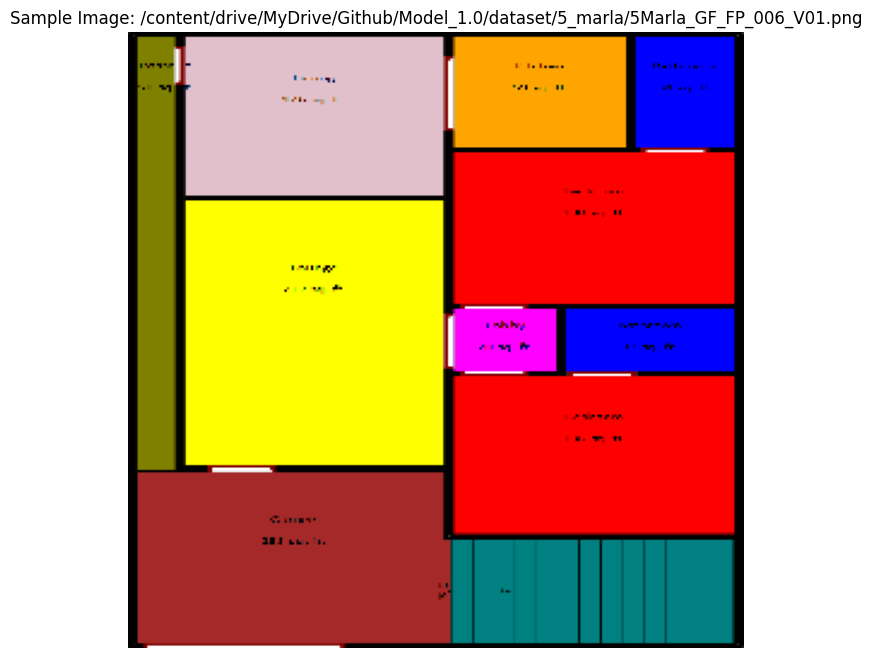

Found 30 images.
Preprocessing dataset...


Creating segmentation maps:   0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-f6ab1d2ad108>:85: RuntimeWarning: overflow encountered in scalar subtract
  key=lambda c: sum((c[i] - rgb[i])**2 for i in range(3)))
<ipython-input-15-f6ab1d2ad108>:85: RuntimeWarning: overflow encountered in scalar add
  key=lambda c: sum((c[i] - rgb[i])**2 for i in range(3)))
Creating segmentation maps: 100%|██████████| 30/30 [02:12<00:00,  4.41s/it]


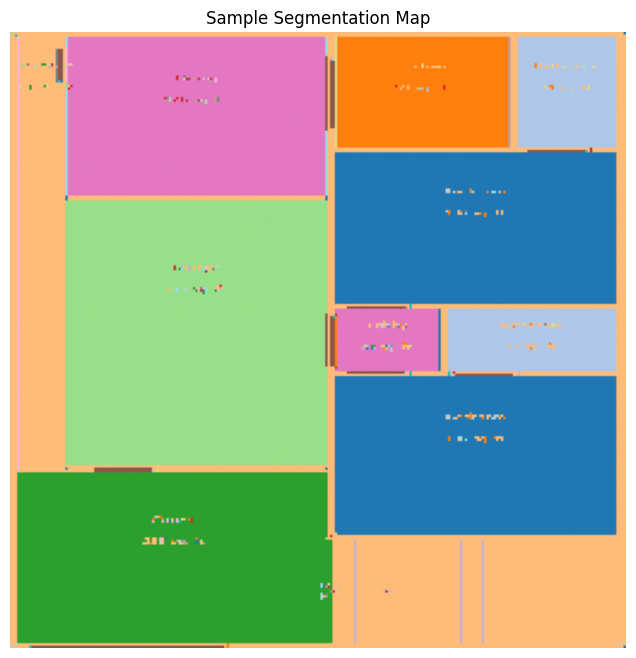

Training set: 24 images, Test set: 6 images


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 65536)          │        262,144 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 256, 256, 1)    │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 4)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          4,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         65,536 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │        131,072 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │        524,288 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,152 │ leaky_re_lu_3[0][0]    │
├──────────────────────

 Total params: 42,210,904 (161.02 MB)

 Trainable params: 42,201,944 (160.99 MB)

 Non-trainable params: 8,960 (35.00 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 65536)          │        262,144 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 256, 256, 1)    │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 256, 256, 4)    │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │          4,096 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 128, 128, 64)   │              0 │ conv2d_8[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │        131,072 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 64, 64, 128)    │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 256)    │        524,288 │ leaky_re_lu_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 32, 32, 256)    │          1,024 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 512)    │      2,097,152 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 16, 16, 512)    │          2,048 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,030,529 (11.56 MB)

 Trainable params: 3,028,737 (11.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Starting training...


Epoch 1/50:   0%|          | 0/2 [00:00<?, ?it/s]


ValueError: in user code:

    File "<ipython-input-18-a3e3f9252a6f>", line 83, in train_step  *
        disc_generated_output = self.discriminator([gen_output, condition], training=True)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "discriminator" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(16, 128, 128, 24)


In [19]:
# Check if the dataset exists
if not os.path.exists(DATASET_PATH):
    raise ValueError(f"Dataset not found at {DATASET_PATH}. Please upload your dataset to Google Drive or check the path.")

# Print dataset structure
print("Dataset structure:")
for plot_type in PLOT_TYPES:
    plot_dir = os.path.join(DATASET_PATH, plot_type)
    if os.path.exists(plot_dir):
        files = [f for f in os.listdir(plot_dir) if f.endswith('.png')]
        print(f"  - {plot_type}: {len(files)} images")

# Initialize the floor plan generator
print("\nInitializing Floor Plan Generator...")
generator = FloorPlanGenerator(DATASET_PATH)

# Set a lower number of epochs for demonstration
training_epochs = 50  # You can increase this for better results

# Train the model
print(f"\nStarting training for {training_epochs} epochs...")
generator_path = generator.train(epochs=training_epochs)

## 6. Generating Floor Plans

Let's generate some floor plans for each plot type.

In [ ]:
# Generate floor plans for each plot type
for plot_type in PLOT_TYPES:
    print(f"\nGenerating floor plans for {plot_type}:")

    # Generate 3 samples for this plot type
    floor_plans = generator.generate_floor_plan(plot_type, num_samples=3)

    # Export the floor plans in different formats
    for i, floor_plan in enumerate(floor_plans):
        # Create output directory
        output_dir = os.path.join(OUTPUT_DIR, plot_type)
        os.makedirs(output_dir, exist_ok=True)

        # Export as PNG
        generator.export_floor_plan(
            floor_plan,
            os.path.join(output_dir, f"floor_plan_{i+1}.png"),
            format='png'
        )

        # Export as SVG
        generator.export_floor_plan(
            floor_plan,
            os.path.join(output_dir, f"floor_plan_{i+1}.svg"),
            format='svg'
        )

## 7. Create Color Legend

Let's create a legend for the color-coded room types.

In [ ]:
def create_legend():
    """
    Create a legend for the color-coded room types.
    """
    # Create a figure for the legend
    plt.figure(figsize=(12, 10))

    # Create patches for legend
    patches = []
    labels = []

    for room_type, color in COLOR_MAP.items():
        # Convert RGB color to matplotlib format (0-1 range)
        color_normalized = [c / 255 for c in color]

        # Create a patch and add it to the list
        patch = plt.Rectangle((0, 0), 1, 1, fc=color_normalized)
        patches.append(patch)
        labels.append(room_type)

    # Create the legend
    plt.legend(patches, labels, loc='center', fontsize=12)
    plt.axis('off')
    plt.title('Floor Plan Color Legend', fontsize=16)

    # Save the legend
    legend_path = os.path.join(OUTPUT_DIR, 'color_legend.png')
    plt.savefig(legend_path)
    plt.show()
    print(f"Color legend saved to {legend_path}")

# Create the color legend
create_legend()

## 8. Save Results to Drive

Let's save the trained model and generated floor plans to Google Drive.

In [ ]:
def save_to_drive(local_path, drive_path):
    """
    Save files from Colab to Google Drive.

    Args:
        local_path: Path to the local files in Colab
        drive_path: Path to save the files in Google Drive
    """
    # Create the directory in Drive if it doesn't exist
    os.makedirs(drive_path, exist_ok=True)

    # Copy the files
    !cp -r {local_path}/* {drive_path}/

    print(f"Files copied from {local_path} to {drive_path}")

# Set the path in Google Drive to save the results
drive_output_path = '/content/drive/MyDrive/FYP-FP-Generator-Model/output'

# Create the directory if it doesn't exist
os.makedirs(drive_output_path, exist_ok=True)

# Save the results to Drive
save_to_drive(OUTPUT_DIR, drive_output_path)

## 9. Conclusion

You have successfully implemented and trained a floor plan generator model!

### What We've Accomplished:

1. Loaded and preprocessed the floor plan dataset
2. Built a Conditional GAN model architecture
3. Trained the model to generate floor plans based on plot type
4. Generated sample floor plans for each plot type
5. Saved the results to Google Drive

### Next Steps:

1. Train the model for more epochs to improve results
2. Implement more sophisticated evaluation metrics
3. Add constraints to ensure architectural validity
4. Develop a more interactive interface for floor plan generation

The trained model and generated floor plans are now available in your Google Drive at: `{drive_output_path}`.